# NeuralNetwork Model
This notebook is part of Jane-street-market-prediction data science project. Unlike the previous notebook (XGBOOST model),
in this Part data science project i use TensorFlow Neural Network to build Model. However, all data preparation processes are the same.

In [1]:
import pandas as pd
import numpy as np

sample_prediction_df  = pd.read_csv("../input/jane-street-market-prediction/example_sample_submission.csv",index_col ='ts_id')
data_test= pd.read_csv("../input/jane-street-market-prediction/example_test.csv",index_col ='ts_id')

In [2]:
import dask.dataframe as dd

train = dd.read_csv("../input/jane-street-market-prediction/train.csv").set_index('ts_id').compute()
print("Data size:", train.shape)

Data size: (2390491, 137)


In [3]:
numerical_cols = train.columns

In [4]:
for i in numerical_cols:
    train[i]= train[i].fillna(0)

In [5]:
train = train[train['weight'] != 0]

train['action'] = ((train['weight'].values * train['resp'].values) > 0).astype('int')

In [6]:
y = train.loc[:, 'action']

In [7]:
train = train.loc[:, train.columns.str.contains('feature','date')]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, y, 
                                                                train_size=0.8,
                                                                random_state=0)

# Build Model

In this model i use `BatchNormalization()` and `Dropout()` to optimize the function

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[130]),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

let's `early_stopping` to prevent our model from overfitting.

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

training our model!

In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
6192/6192 [==============================] - 73s 12ms/step - loss: 0.7000 - binary_accuracy: 0.5165 - val_loss: 0.6913 - val_binary_accuracy: 0.5212
Epoch 2/200
6192/6192 [==============================] - 70s 11ms/step - loss: 0.6910 - binary_accuracy: 0.5227 - val_loss: 0.6903 - val_binary_accuracy: 0.5216
Epoch 3/200
6192/6192 [==============================] - 71s 11ms/step - loss: 0.6899 - binary_accuracy: 0.5253 - val_loss: 0.6892 - val_binary_accuracy: 0.5250
Epoch 4/200
6192/6192 [==============================] - 70s 11ms/step - loss: 0.6886 - binary_accuracy: 0.5286 - val_loss: 0.6877 - val_binary_accuracy: 0.5270
Epoch 5/200
6192/6192 [==============================] - 70s 11ms/step - loss: 0.6868 - binary_accuracy: 0.5313 - val_loss: 0.6863 - val_binary_accuracy: 0.5336
Epoch 6/200
6192/6192 [==============================] - 71s 11ms/step - loss: 0.6847 - binary_accuracy: 0.5350 - val_loss: 0.6850 - val_binary_accuracy: 0.5355
Epoch 7/200
6192/6192 [===========

Best Validation Loss: 0.6103
Best Validation Accuracy: 0.6577


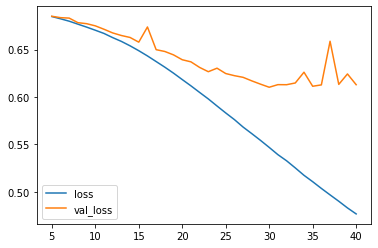

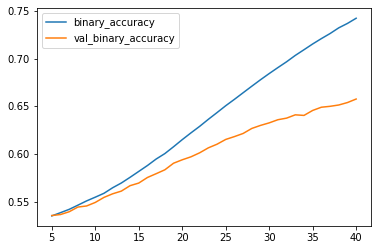

In [13]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
import janestreet
# initiation of the environment
env = janestreet.make_env()
# an iterator to loops over the test set
iter_test = env.iter_test() 

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    #We will specify the X_test from our test data (features)
    X_test = test_df.loc[:, test_df.columns.str.contains('feature','date')]
    #Replace the missing value with -999
    X_test.fillna(0)
    #Predict using our X_test
    y_preds = model.predict(X_test)
    #Make / store our prediction results in sample_pred_df
    sample_prediction_df.action = y_preds
    env.predict(sample_prediction_df)